Projet OC n°5 : Segmenter des clients d'un site e-commerce
==========================================================

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

import sqlite3
import time

from ipywidgets import interact
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.metrics import mean_squared_error

I. Interactions avec la base de données
***************************************

In [2]:
# Connexion à la base de donnée
conn = sqlite3.connect('../Data/olist.db')

    A. Présentation générale des données

![Olist DB](images/olist_db.png)

    B. Calcul du RFM

In [3]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()

# Récupération de la date de la dernière commande par client
cur.execute("""
SELECT customer_unique_id, MAX(order_purchase_timestamp) AS last_purchase_date
FROM customers 
JOIN orders ON customers.customer_id = orders.customer_id
GROUP BY customer_unique_id;
""")
Recency = cur.fetchall()

# Calcul de la fréquence des commandes par client
cur.execute("""
SELECT customer_unique_id, COUNT(order_id) AS total_orders
FROM customers 
JOIN orders ON customers.customer_id = orders.customer_id
GROUP BY customer_unique_id;
""")
Frequency = cur.fetchall()

# Calcul du montant total dépensé par client
cur.execute("""
SELECT customer_unique_id, SUM(payment_value) AS total_spent
FROM customers 
JOIN orders ON customers.customer_id = orders.customer_id
JOIN order_pymts ON orders.order_id = order_pymts.order_id
GROUP BY customer_unique_id;
""")
Monetary = cur.fetchall()

# Récupération des clients ayant passé plus d'une commande
cur.execute("""
SELECT COUNT(o.order_id) AS Orders_number, o.order_id, c.customer_id, c.customer_unique_id
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_unique_id
HAVING COUNT(o.order_id) > 1
""")
Clients = cur.fetchall()

# Calcul de la note moyenne des avis par client
cur.execute("""
SELECT c.customer_unique_id, AVG(r.review_score) AS average_review_score
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_reviews r ON o.order_id = r.order_id
GROUP BY c.customer_unique_id;
""")
Review = cur.fetchall()

In [4]:
print("Date de la dernière commande par client")
Recency

Date de la dernière commande par client


[('0000366f3b9a7992bf8c76cfdf3221e2', '2018-05-10 10:56:27'),
 ('0000b849f77a49e4a4ce2b2a4ca5be3f', '2018-05-07 11:11:27'),
 ('0000f46a3911fa3c0805444483337064', '2017-03-10 21:05:03'),
 ('0000f6ccb0745a6a4b88665a16c9f078', '2017-10-12 20:29:41'),
 ('0004aac84e0df4da2b147fca70cf8255', '2017-11-14 19:45:42'),
 ('0004bd2a26a76fe21f786e4fbd80607f', '2018-04-05 19:33:16'),
 ('00050ab1314c0e55a6ca13cf7181fecf', '2018-04-20 12:57:23'),
 ('00053a61a98854899e70ed204dd4bafe', '2018-02-28 11:15:41'),
 ('0005e1862207bf6ccc02e4228effd9a0', '2017-03-04 23:32:12'),
 ('0005ef4cd20d2893f0d9fbd94d3c0d97', '2018-03-12 15:22:12'),
 ('0006fdc98a402fceb4eb0ee528f6a8d4', '2017-07-18 09:23:10'),
 ('00082cbe03e478190aadbea78542e933', '2017-11-19 15:22:02'),
 ('00090324bbad0e9342388303bb71ba0a', '2018-03-24 14:44:41'),
 ('000949456b182f53c18b68d6babc79c1', '2018-04-23 09:55:46'),
 ('000a5ad9c4601d2bbdd9ed765d5213b3', '2017-08-11 13:45:15'),
 ('000bfa1d2f1a41876493be685390d6d3', '2017-09-29 14:46:58'),
 ('000c8

In [5]:
print("Fréquence des commandes par client")
Frequency

Fréquence des commandes par client


[('0000366f3b9a7992bf8c76cfdf3221e2', 1),
 ('0000b849f77a49e4a4ce2b2a4ca5be3f', 1),
 ('0000f46a3911fa3c0805444483337064', 1),
 ('0000f6ccb0745a6a4b88665a16c9f078', 1),
 ('0004aac84e0df4da2b147fca70cf8255', 1),
 ('0004bd2a26a76fe21f786e4fbd80607f', 1),
 ('00050ab1314c0e55a6ca13cf7181fecf', 1),
 ('00053a61a98854899e70ed204dd4bafe', 1),
 ('0005e1862207bf6ccc02e4228effd9a0', 1),
 ('0005ef4cd20d2893f0d9fbd94d3c0d97', 1),
 ('0006fdc98a402fceb4eb0ee528f6a8d4', 1),
 ('00082cbe03e478190aadbea78542e933', 1),
 ('00090324bbad0e9342388303bb71ba0a', 1),
 ('000949456b182f53c18b68d6babc79c1', 1),
 ('000a5ad9c4601d2bbdd9ed765d5213b3', 1),
 ('000bfa1d2f1a41876493be685390d6d3', 1),
 ('000c8bdb58a29e7115cfc257230fb21b', 1),
 ('000d460961d6dbfa3ec6c9f5805769e1', 1),
 ('000de6019bb59f34c099a907c151d855', 1),
 ('000e309254ab1fc5ba99dd469d36bdb4', 1),
 ('000ec5bff359e1c0ad76a81a45cb598f', 1),
 ('000ed48ceeb6f4bf8ad021a10a3c7b43', 1),
 ('000fbf0473c10fc1ab6f8d2d286ce20c', 1),
 ('0010a452c6d13139e50b57f19f52e04

In [6]:
print("Montant total dépensé par client")
Monetary

Montant total dépensé par client


[('0000366f3b9a7992bf8c76cfdf3221e2', 141.9),
 ('0000b849f77a49e4a4ce2b2a4ca5be3f', 27.19),
 ('0000f46a3911fa3c0805444483337064', 86.22),
 ('0000f6ccb0745a6a4b88665a16c9f078', 43.62),
 ('0004aac84e0df4da2b147fca70cf8255', 196.89),
 ('0004bd2a26a76fe21f786e4fbd80607f', 166.98),
 ('00050ab1314c0e55a6ca13cf7181fecf', 35.38),
 ('00053a61a98854899e70ed204dd4bafe', 419.18),
 ('0005e1862207bf6ccc02e4228effd9a0', 150.12),
 ('0005ef4cd20d2893f0d9fbd94d3c0d97', 129.76),
 ('0006fdc98a402fceb4eb0ee528f6a8d4', 29.0),
 ('00082cbe03e478190aadbea78542e933', 126.26),
 ('00090324bbad0e9342388303bb71ba0a', 63.66),
 ('000949456b182f53c18b68d6babc79c1', 82.05),
 ('000a5ad9c4601d2bbdd9ed765d5213b3', 91.28),
 ('000bfa1d2f1a41876493be685390d6d3', 46.85),
 ('000c8bdb58a29e7115cfc257230fb21b', 29.0),
 ('000d460961d6dbfa3ec6c9f5805769e1', 36.68),
 ('000de6019bb59f34c099a907c151d855', 257.44),
 ('000e309254ab1fc5ba99dd469d36bdb4', 78.42),
 ('000ec5bff359e1c0ad76a81a45cb598f', 27.75),
 ('000ed48ceeb6f4bf8ad021a10a

In [7]:
print("Clients ayant passé plus d'une commande")
Clients

Clients ayant passé plus d'une commande


[(2,
  'c306eca42d32507b970739b5b6a5a33a',
  '24b0e2bd287e47d54d193e7bbb51103f',
  '00172711b30d52eea8b313a7f2cced02'),
 (2,
  'a61d617fbe5bd006e40d3a0988fc844b',
  '1b4a75b3478138e99902678254b260f4',
  '004288347e5e88a27ded2bb23747066c'),
 (2,
  '90ae229a4addcfead792e2564554f09c',
  '49cf243e0d353cd418ca77868e24a670',
  '004b45ec5c64187465168251cd1c9c2f'),
 (2,
  '2cfc79d9582e9135c0a9b61fa60e6b21',
  'f530197ea86ced9488a03d055e118ebf',
  '0058f300f57d7b93c477a131a59b36c3'),
 (2,
  '7d32c87acba91ed87ebd98310fe1c54d',
  '876356df457f952458a764348e1858bc',
  '00a39521eb40f7012db50455bf083460'),
 (2,
  '64307ceb91666760cf3ff463618302fd',
  'c0a44bf37d5601228051fc07852f951f',
  '00cc12a6d8b578b8ebd21ea4e2ae8b27'),
 (2,
  'ed0a6265b5b0a292cd537214f401f1fc',
  '71c7265705afd84d030d6adc3122d8dd',
  '011575986092c30523ecb71ff10cb473'),
 (2,
  '93b35affb86435b71ca01a6dd1eab2b1',
  '3db635076c27c1d6a8618bc5a6e70ad2',
  '011b4adcd54683b480c4d841250a987f'),
 (2,
  'e49d0607832db7c3b1343764225d8df6

In [8]:
print("Note moyenne des avis par client")
Review

Note moyenne des avis par client


[('0000366f3b9a7992bf8c76cfdf3221e2', 5.0),
 ('0000b849f77a49e4a4ce2b2a4ca5be3f', 4.0),
 ('0000f46a3911fa3c0805444483337064', 3.0),
 ('0000f6ccb0745a6a4b88665a16c9f078', 4.0),
 ('0004aac84e0df4da2b147fca70cf8255', 5.0),
 ('0004bd2a26a76fe21f786e4fbd80607f', 4.0),
 ('00050ab1314c0e55a6ca13cf7181fecf', 4.0),
 ('00053a61a98854899e70ed204dd4bafe', 1.0),
 ('0005e1862207bf6ccc02e4228effd9a0', 4.0),
 ('0005ef4cd20d2893f0d9fbd94d3c0d97', 1.0),
 ('0006fdc98a402fceb4eb0ee528f6a8d4', 3.0),
 ('00082cbe03e478190aadbea78542e933', 5.0),
 ('00090324bbad0e9342388303bb71ba0a', 5.0),
 ('000949456b182f53c18b68d6babc79c1', 4.0),
 ('000a5ad9c4601d2bbdd9ed765d5213b3', 4.0),
 ('000bfa1d2f1a41876493be685390d6d3', 4.5),
 ('000c8bdb58a29e7115cfc257230fb21b', 5.0),
 ('000d460961d6dbfa3ec6c9f5805769e1', 5.0),
 ('000de6019bb59f34c099a907c151d855', 2.0),
 ('000e309254ab1fc5ba99dd469d36bdb4', 3.0),
 ('000ec5bff359e1c0ad76a81a45cb598f', 5.0),
 ('000ed48ceeb6f4bf8ad021a10a3c7b43', 5.0),
 ('000fbf0473c10fc1ab6f8d2d286ce

    C. Conversion et Feature Engineering : Création de features par client

In [9]:
# Conversion des résultats pour la date de la dernière commande (Recency)
recency = pd.DataFrame(Recency, columns=['customer_unique_id', 'last_purchase_date'])

# Conversion des résultats pour la fréquence des commandes (Frequency)
frequency = pd.DataFrame(Frequency, columns=['customer_unique_id', 'total_orders'])

# Conversion des résultats pour le montant total dépensé par client (Monetary)
data_monetary = pd.DataFrame(Monetary, columns=['customer_unique_id', 'total_spent'])

# Conversion des résultats pour les clients ayant passé plus d'une commande (Clients)
clients = pd.DataFrame(Clients, columns=['Orders_number', 'order_id', 'customer_id', 'customer_unique_id'])

# Création d'une colonne 'Importance' pour indiquer si le client a passé plus d'une commande
clients['Importance'] = True
clients = clients[['customer_unique_id', 'Importance']]

# Conversion des résultats pour la note moyenne des avis (Review)
review = pd.DataFrame(Review, columns=['customer_unique_id', 'average_review_score'])

# Fusion des DataFrames en fonction de 'customer_unique_id'
data = recency.merge(frequency, on='customer_unique_id', how='outer')
data = data.merge(data_monetary, on='customer_unique_id', how='outer')
data = data.merge(review, on='customer_unique_id', how='outer')
data = data.merge(clients, on='customer_unique_id', how='outer')

# Remplir les valeurs manquantes dans 'Importance' par False pour les clients qui n'ont pas passé plus d'une commande
data['Importance'] = data['Importance'].fillna(False)

# Réorganisation des colonnes pour plus de clarté
data = data[['customer_unique_id', 'Importance', 'last_purchase_date', 'total_orders', 'total_spent', 'average_review_score']]

# Renommer les colonnes pour correspondre aux indicateurs RFM et aux informations sur les avis
data.columns = ['CustomerId', 'Importance', 'Recency', 'Frequency', 'Monetary', 'Review']

# Afficher le DataFrame final
data.head()

,CustomerId,Importance,Recency,Frequency,Monetary,Review
0,0000366f3b9a7992bf8c76cfdf3221e2,False,2018-05-10 10:56:27,1,141.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,False,2018-05-07 11:11:27,1,27.19,4.0
2,0000f46a3911fa3c0805444483337064,False,2017-03-10 21:05:03,1,86.22,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,False,2017-10-12 20:29:41,1,43.62,4.0
4,0004aac84e0df4da2b147fca70cf8255,False,2017-11-14 19:45:42,1,196.89,5.0


II. Exploration et nettoyage des données
****************************************

    A. Exploration

In [10]:
# Récupération des dimensions du DataFrame
datas = data.shape
columns = datas[1]
rows = datas[0]

# Comptage des types de données
data_type = data.dtypes.value_counts()
var_qual = data_type.iloc[1]
var_quant = data_type.iloc[0]

# Calcul du nombre total de valeurs
values = data.size

# Affichage des informations importantes
print("\033[1m" + "\033[91m" + "Informations importantes :" + "\033[0m" + "\n")
print(f"Total colonnes : {columns} variables.\n")
print(f"    -> {var_qual} variables qualitatives.")
print(f"    -> {var_quant} variables quantitatives.")
print(f"\nTotal lignes : {rows} individus.")
print(f"\nTotal : {values} valeurs.")

Informations importantes :

Total colonnes : 6 variables.

    -> 2 variables qualitatives.
    -> 2 variables quantitatives.

Total lignes : 96096 individus.

Total : 576576 valeurs.


In [11]:
data.dtypes.value_counts()

object     2
float64    2
bool       1
int64      1
Name: count, dtype: int64

CustomerId      0
Importance      0
Recency         0
Frequency       0
Monetary        1
Review        716
dtype: int64

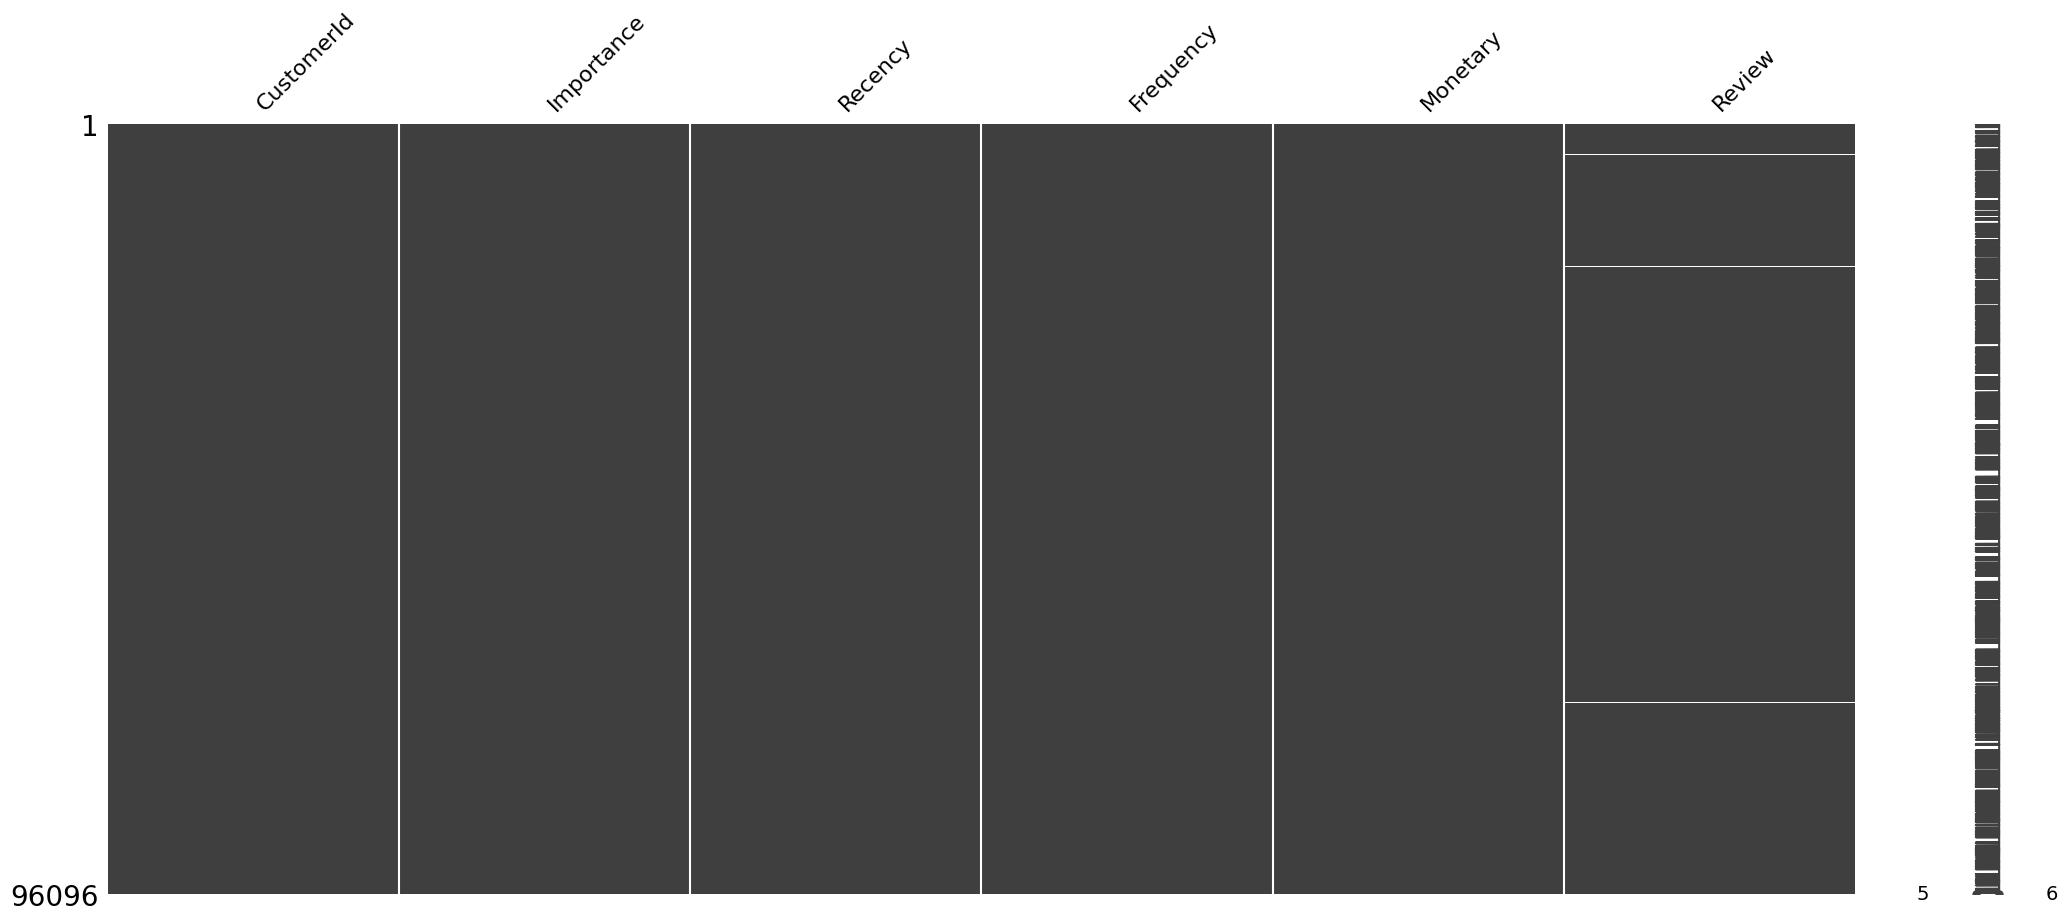

In [12]:
msno.matrix(data)
data.isnull().sum()

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerId  96096 non-null  object 
 1   Importance  96096 non-null  bool   
 2   Recency     96096 non-null  object 
 3   Frequency   96096 non-null  int64  
 4   Monetary    96095 non-null  float64
 5   Review      95380 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 3.8+ MB


In [14]:
# Affichage de la description des variables quantitatives
print("Description des variables quantitatives : \n")
data.describe()

Description des variables quantitatives : 



,Frequency,Monetary,Review
count,96096.000000,96095.000000,95380.000000
mean,1.034809,166.594226,4.084989
std,0.214384,231.428912,1.341571
min,1.000000,0.000000,1.000000
25%,1.000000,63.120000,4.000000
50%,1.000000,108.000000,5.000000
75%,1.000000,183.530000,5.000000
max,17.000000,13664.080000,5.000000


In [15]:
# Sélection des variables qualitatives
var_qual = data.select_dtypes('object')

# Affichage de la description des variables qualitatives
print("Description des variables qualitatives : \n")
for var in var_qual:
    print(var.upper(), " : ", data[var].nunique())
    print(data[var].unique())
    print(data[var].value_counts(), "\n")

Description des variables qualitatives : 

CUSTOMERID  :  96096
['0000366f3b9a7992bf8c76cfdf3221e2' '0000b849f77a49e4a4ce2b2a4ca5be3f'
 '0000f46a3911fa3c0805444483337064' ... 'ffff371b4d645b6ecea244b27531430a'
 'ffff5962728ec6157033ef9805bacc48' 'ffffd2657e2aad2907e67c3e9daecbeb']
CustomerId
0000366f3b9a7992bf8c76cfdf3221e2    1
aa68438532ec59ddec97fa34b08d8e5e    1
aa6d2cdcf78bb23f7f2f89038b3d5d60    1
aa6c1d42efc1e9ff16ec83d91cc16b43    1
aa6bace477b7c573e0d6daddd95f55fa    1
                                   ..
551a0e417b10f992a724b436f2a5588c    1
551a09ef128e5436c555ecc43cfca103    1
5519d48c02e36392f44e56019db3b34d    1
5518a112dff474788c0d52cd4688acff    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: count, Length: 96096, dtype: int64 

RECENCY  :  95834
['2018-05-10 10:56:27' '2018-05-07 11:11:27' '2017-03-10 21:05:03' ...
 '2017-02-07 15:49:16' '2018-05-02 15:17:41' '2017-05-02 20:18:45']
Recency
2018-02-19 15:37:47    3
2018-07-28 13:11:22    3
2017-11-20 11:46:30    3
2018-0

    B. Nettoyage


        1. Identification et traitement des doublons

In [16]:
# Calcul du nombre de ligne en double 
duplicated_lines = data.duplicated().sum()
print(f"{duplicated_lines} lignes en double.")

0 lignes en double.


In [17]:
for var in data.columns:
    # Calcul du nombre de doublons dans la colonne
    nb_duplicates = data[var].dropna().duplicated().sum()
    # Récupération des valeurs dupliquées
    duplicates = data[var].where(data[var].duplicated()).unique()

    # Affichage des informations sur les doublons
    if nb_duplicates > 0:
        print(var, ':', nb_duplicates, 'duplications')
        print('exemples :', duplicates, '\n')

Importance : 96094 duplications
exemples : [nan False True] 

Recency : 262 duplications
exemples : [nan '2018-08-22 10:49:05' '2018-03-05 17:08:53' '2017-10-31 21:42:47'
 '2018-08-16 12:49:01' '2018-02-15 19:23:46' '2018-05-09 11:39:40'
 '2018-07-28 13:14:25' '2018-06-03 16:35:41' '2018-08-02 12:06:10'
 '2018-06-21 09:08:51' '2018-06-10 15:44:20' '2018-08-02 12:05:57'
 '2017-04-28 14:19:11' '2017-11-24 20:35:14' '2018-08-02 12:05:59'
 '2017-03-14 14:29:00' '2017-12-04 22:14:17' '2018-05-17 16:59:11'
 '2018-05-14 20:46:41' '2018-05-09 11:29:02' '2018-05-07 22:14:31'
 '2018-08-07 20:40:26' '2017-12-04 20:09:14' '2017-11-24 21:05:51'
 '2017-11-28 12:00:43' '2018-03-17 15:49:23' '2017-11-24 00:52:54'
 '2018-03-13 20:28:59' '2017-11-24 12:12:36' '2018-05-17 14:20:39'
 '2018-04-11 10:48:14' '2018-08-03 17:13:19' '2017-11-24 17:41:54'
 '2018-08-02 12:06:56' '2018-01-09 23:01:33' '2018-01-18 12:24:35'
 '2018-07-02 16:44:40' '2018-04-08 21:48:15' '2018-06-22 15:56:33'
 '2017-06-05 16:49:45' '2

        2. Identification et traitement des valeurs manquantes

<Axes: >

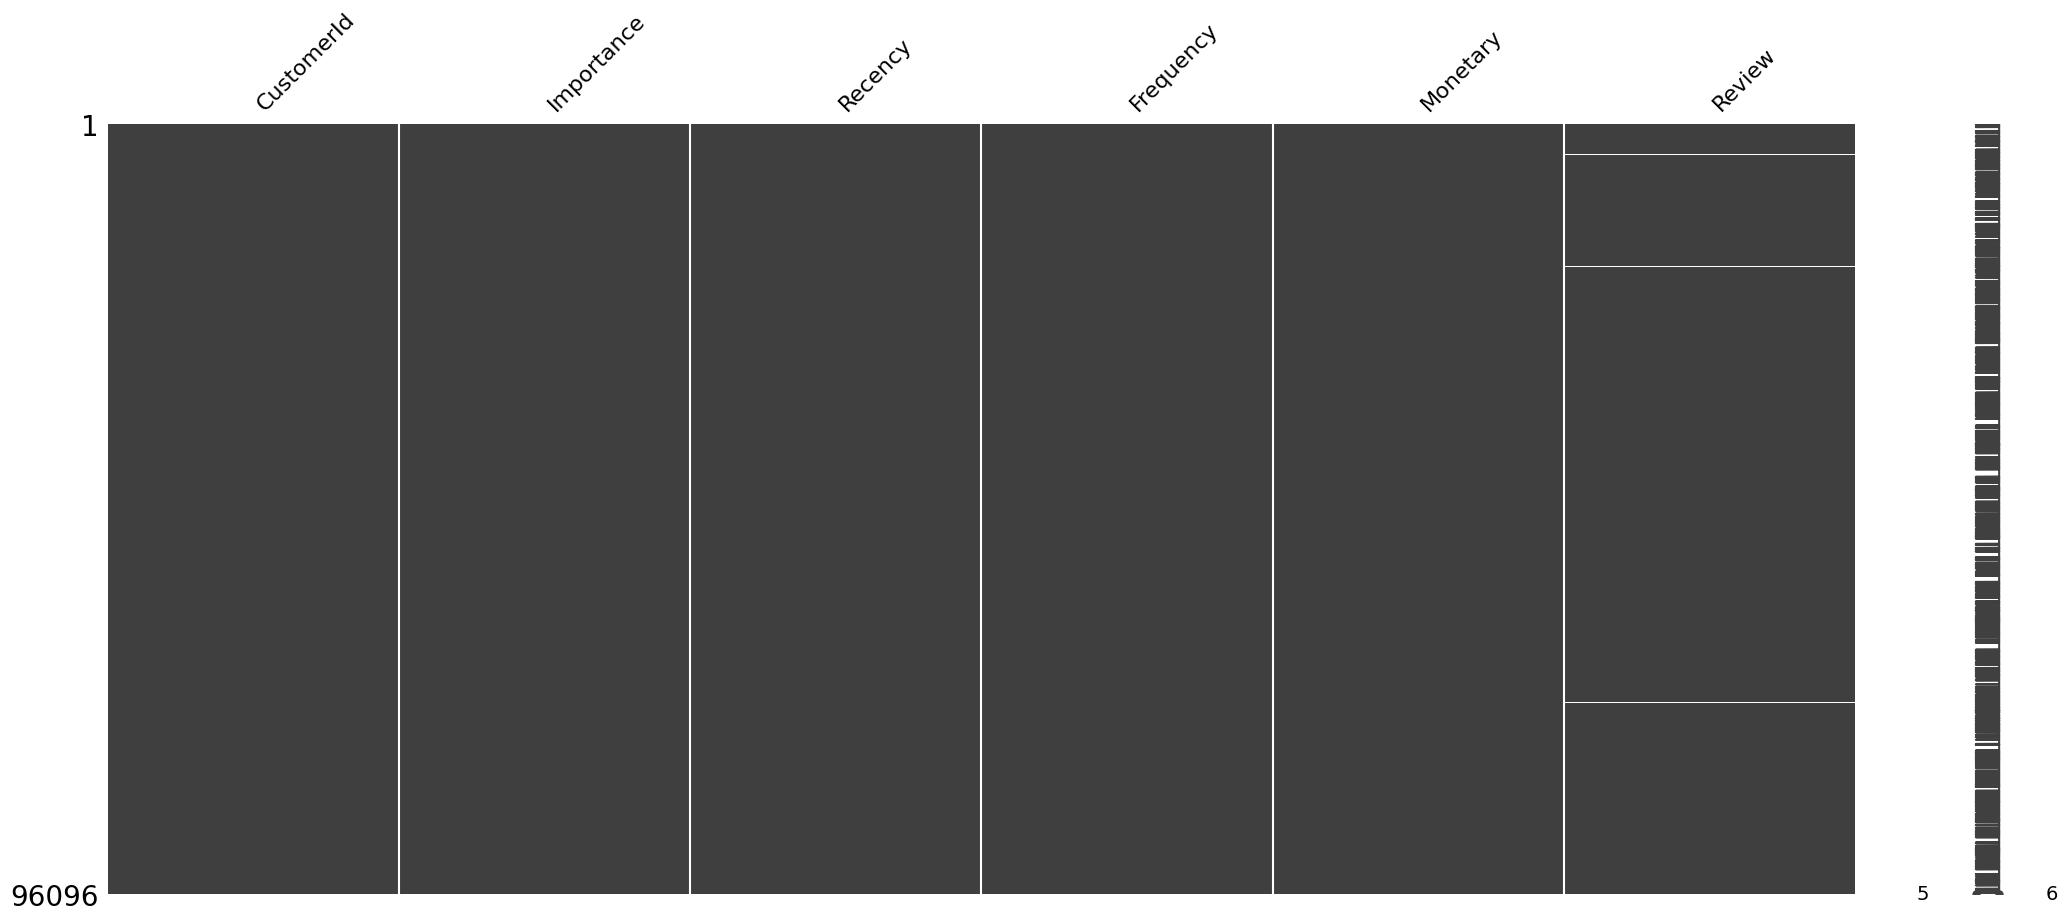

In [18]:
msno.matrix(data)

In [19]:
total_na = data.isna().sum().sum()
total_percent_na = (data.isna().sum().sum() * 100 / data.size).round(2) 
print("Nombre total de valeurs manquantes dans le dataset = ", total_na, "environ", total_percent_na,"% du dataset.")

Nombre total de valeurs manquantes dans le dataset =  717 environ 0.12 % du dataset.


In [20]:
# Initialisation du dictionnaire pour stocker les informations de complétion
completion = {}

# Calcul du nombre de valeurs non nulles, de valeurs manquantes et du pourcentage de valeurs manquantes pour chaque colonne
for var in data.columns:
    nbr_values = data[var].notna().sum()
    na_values = data[var].isna().sum()
    completion[var] = [nbr_values, na_values]
    
# Affichage des informations de complétion pour chaque colonne
print('column_name : nbr_values -> nbr_of_Na', '\n')
for var in completion:
    nbr_values = completion[var][0]
    na_values = completion[var][1]
    print(f'{var} : {nbr_values} valeurs -> {int(na_values)} Na')

column_name : nbr_values -> nbr_of_Na 

CustomerId : 96096 valeurs -> 0 Na
Importance : 96096 valeurs -> 0 Na
Recency : 96096 valeurs -> 0 Na
Frequency : 96096 valeurs -> 0 Na
Monetary : 96095 valeurs -> 1 Na
Review : 95380 valeurs -> 716 Na


<Axes: >

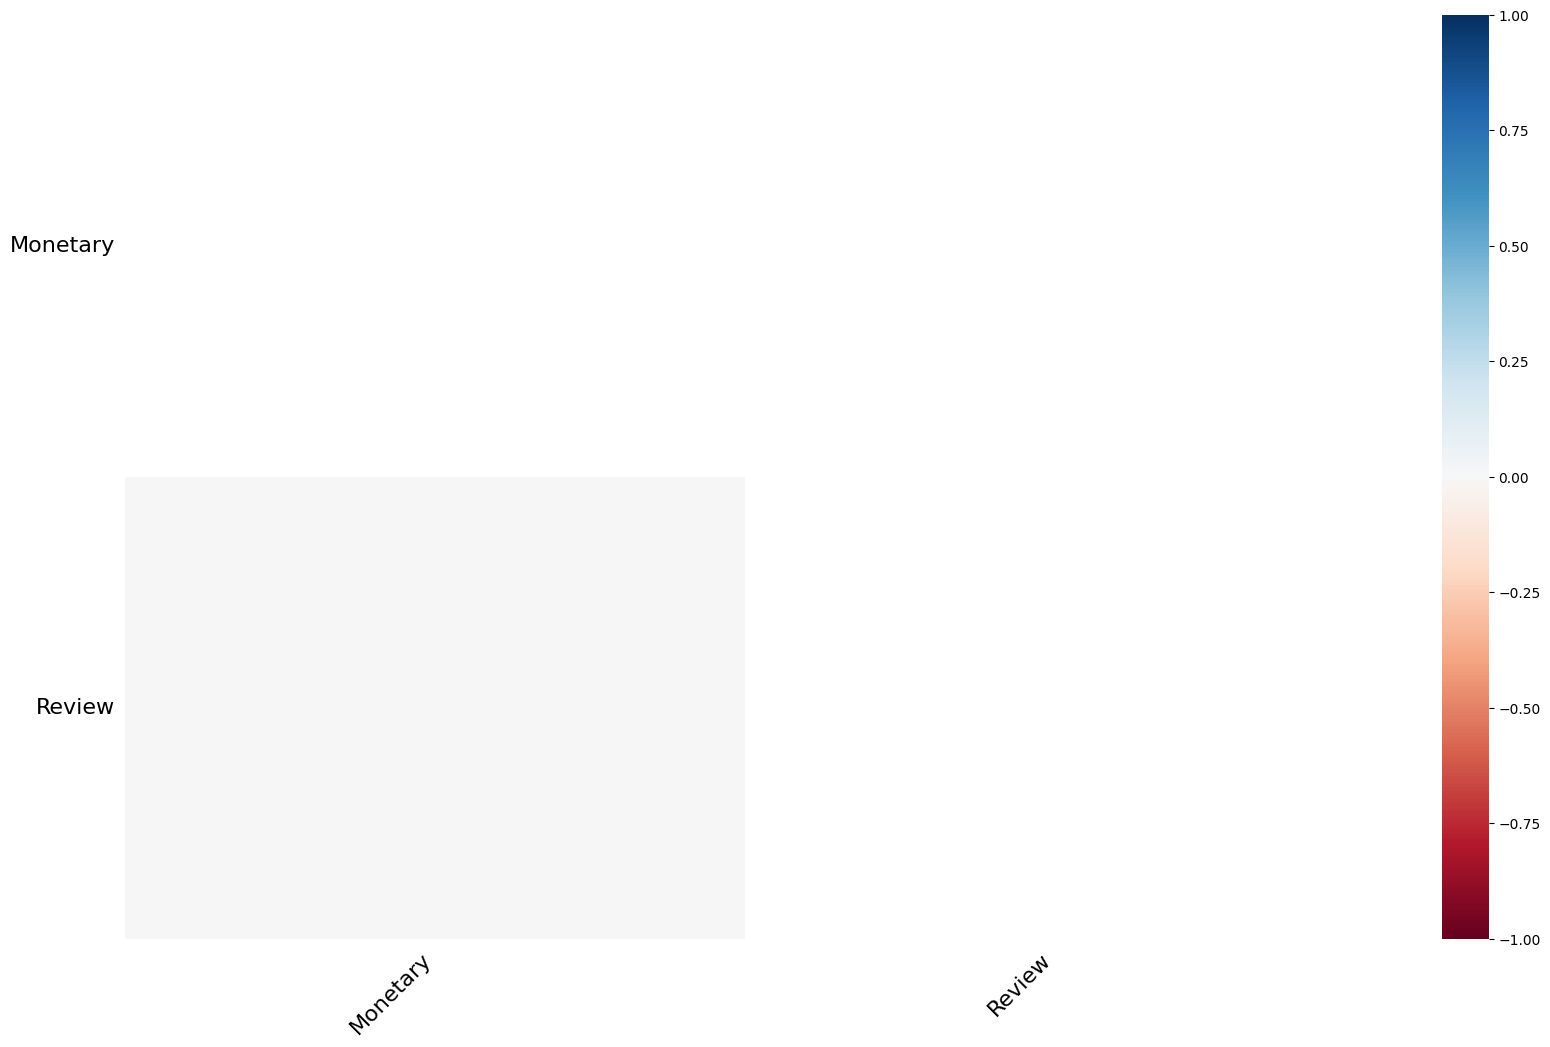

In [21]:
msno.heatmap(data)

<Axes: >

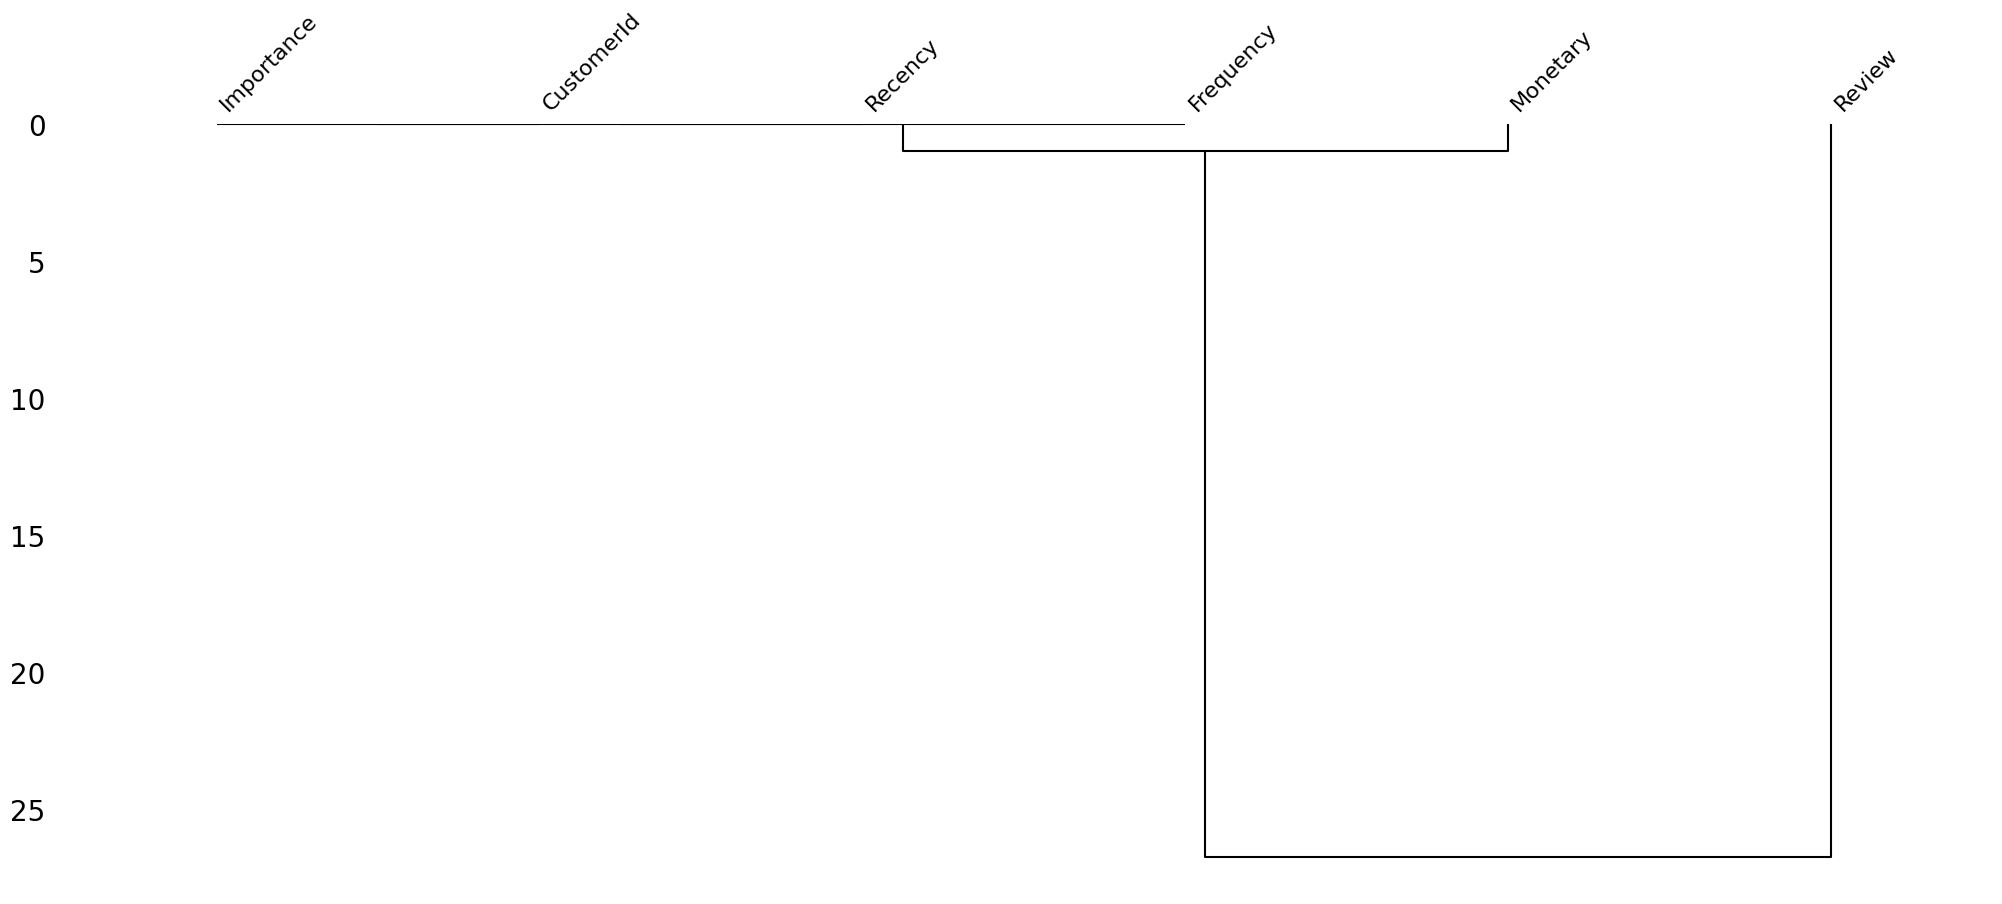

In [22]:
msno.dendrogram(data)

L'analyse du dendrogramme indique que les données manquantes dans notre ensemble sont de type MNAR (Missing Not At Random). Cette hypothèse est renforcée par la corrélation observée entre la variable 'Monetary', qui présente des valeurs manquantes, et la variable 'Review'.

    Pour la variable Monetary : 
*******************************    
    Nous avons détecté une seule valeur manquante dans la variable 'Monetary'. Étant donné que cette absence concerne moins de 0,001% de l'ensemble des données, nous avons choisi une approche prudente en supprimant cette observation spécifique. Cette décision permet de maintenir l'intégrité et la qualité des données destinées au clustering.

In [23]:
# Supprimer uniquement les lignes où 'Monetary' a des valeurs manquantes
cleaned_data = data.dropna(subset=['Monetary'])

# Vérifier à nouveau les valeurs manquantes dans le DataFrame nettoyé
missing_values_clean = cleaned_data.isnull().sum()
print("Valeurs manquantes après nettoyage :\n", missing_values_clean)

Valeurs manquantes après nettoyage :
 CustomerId      0
Importance      0
Recency         0
Frequency       0
Monetary        0
Review        716
dtype: int64


    Pour la variable Review : 
***************************** 
    Nous avons détecté 716 valeurs manquantes dans la variable 'Review', ce qui représente 0,74 % de l'ensemble des données. Étant donné que ces absences sont classifiées comme MNAR (Missing Not At Random), plusieurs stratégies d'imputation sont envisageables pour pallier ce manque :
    
        - Imputation par la méthode des K-plus proches voisins (KNN).
        - Imputation basée sur l'algorithme MissForest.
        - Imputation par régression.
    
    Avant de décider de la méthode d'imputation, nous allons mené une série de tests de normalité pour évaluer la distribution de la variable Review

In [24]:
# Niveau de signification (alpha)
alpha = 0.05

# Liste pour stocker les résultats
tests = []

# Récupérer les valeurs de la variable
values = data['Review'].dropna()

# Effectuer les tests de normalité
shapiro_test = stats.shapiro(values)
ks_test = stats.kstest(values, 'norm')
ad_test = stats.anderson(values, dist='norm')
dagostino_test = stats.normaltest(values)
lilliefors_test = lilliefors(values, dist='norm')

# Ajouter les résultats à la liste
tests.extend([
    {'Nom du test': 'Shapiro-Wilk',
     'Statistique de test': shapiro_test[0],
     'p-valeur': shapiro_test[1],
     'Normalité': 'Oui' if shapiro_test[1] > alpha else 'Non'
    },
    {'Nom du test': 'Kolmogorov-Smirnov',
     'Statistique de test': ks_test.statistic,
     'p-valeur': ks_test.pvalue,
     'Normalité': 'Oui' if ks_test.pvalue > alpha else 'Non'
    },
    {'Nom du test': 'Anderson-Darling',
     'Statistique de test': ad_test.statistic,
     'p-valeur': None,  # La p-valeur n'est pas directement fournie par le test d'Anderson-Darling
     'Normalité': 'Oui' if any(ad_test.statistic < crit_val for crit_val in ad_test.critical_values) else 'Non'
    },
    {'Nom du test': "D'Agostino-Pearson",
     'Statistique de test': dagostino_test.statistic,
     'p-valeur': dagostino_test.pvalue,
     'Normalité': 'Oui' if dagostino_test.pvalue > alpha else 'Non'
    },
    {'Nom du test': 'Lilliefors',
     'Statistique de test': lilliefors_test[0],
     'p-valeur': lilliefors_test[1],
     'Normalité': 'Oui' if lilliefors_test[1] > alpha else 'Non'
    }
			])

# Création d'un DataFrame avec les résultats
test_results = pd.DataFrame(tests)

test_results

C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Nom du test,Statistique de test,p-valeur,Normalité
0,Shapiro-Wilk,0.691650,0.000,Non
1,Kolmogorov-Smirnov,0.863798,0.000,Non
2,Anderson-Darling,12118.263484,NaN,Non
3,D'Agostino-Pearson,18164.113444,0.000,Non
4,Lilliefors,0.324883,0.001,Non


Les tests de normalité ont confirmé que les données ne sont pas normalement distribuées. Cela nous oriente vers des méthodes d'imputation non paramétriques comme KNN, avec MissForest en option si KNN ne s'avère pas concluant. Ces choix sont plus appropriés pour traiter des données manquantes MNAR et avec des distributions non normales.

In [25]:
# Création d'un DataFrame spécifique pour l'imputation KNN
knn_data = cleaned_data.copy()
var = 'Review'

# Identification des indices des valeurs non manquantes
not_na = knn_data[var].notna()

# Normalisation de la colonne 'Review' en excluant les valeurs NaN
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(knn_data.loc[not_na, [var]])

# Réintégration des valeurs normalisées dans le DataFrame original
knn_data.loc[not_na, var] = normalized_data.flatten()
knn_data.head()

,CustomerId,Importance,Recency,Frequency,Monetary,Review
0,0000366f3b9a7992bf8c76cfdf3221e2,False,2018-05-10 10:56:27,1,141.90,1.00
1,0000b849f77a49e4a4ce2b2a4ca5be3f,False,2018-05-07 11:11:27,1,27.19,0.75
2,0000f46a3911fa3c0805444483337064,False,2017-03-10 21:05:03,1,86.22,0.50
3,0000f6ccb0745a6a4b88665a16c9f078,False,2017-10-12 20:29:41,1,43.62,0.75
4,0004aac84e0df4da2b147fca70cf8255,False,2017-11-14 19:45:42,1,196.89,1.00


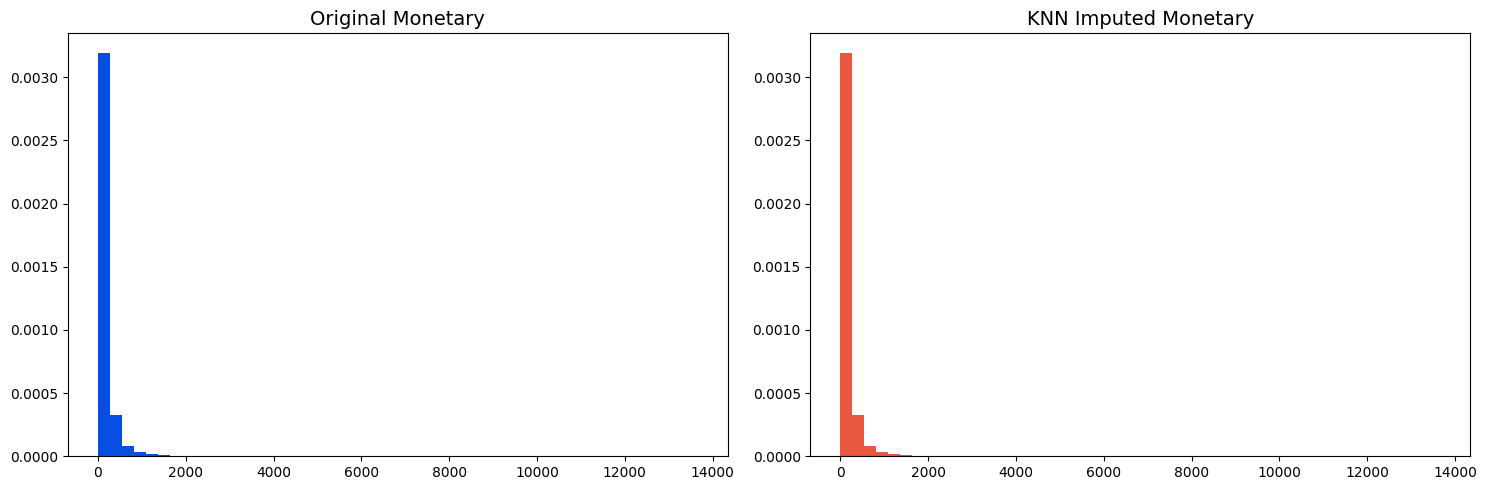

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

# Affichage des données originales
axes[0].hist(cleaned_data['Monetary'].dropna(), bins=50, color='#094ee3', density=True, edgecolor='none')
axes[0].set_title('Original Monetary', fontsize=14)

# Affichage des données normalisées
axes[1].hist(knn_data['Monetary'], bins=50, color='#e85741', density=True, edgecolor='none')
axes[1].set_title('KNN Imputed Monetary', fontsize=14)

plt.tight_layout()
plt.show()

Je choisis de remplacer les valeurs manquantes via KNN

In [27]:
# Sélection de la colonne 'Review' pour l'imputation KNN
knn_data_var = knn_data[['Review']]

# Sélectionner un sous-ensemble de données sans valeurs manquantes
subset = knn_data_var[knn_data_var['Review'].notna()]

# Tester différents nombres de voisins
nbr_neighbors = [3, 5, 7, 9, 11]
results = []

for n_neighbors in nbr_neighbors:
    start_time = time.time()
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_values = imputer.fit_transform(subset)
    end_time = time.time()
    mse = mean_squared_error(subset['Review'], imputed_values[:, 0])
    results.append({'n_neighbors': n_neighbors, 'MSE': mse, 'Time (s)': end_time - start_time})

# Convertir les résultats en DataFrame
knn_imputed_data = pd.DataFrame(results)

# Afficher les résultats
print(knn_imputed_data)

# Choisir le nombre de voisins avec l'erreur la plus faible
best_n_neighbors = nbr_neighbors[np.argmin(knn_imputed_data['MSE'])]
print(f"Meilleur nombre de voisins : {best_n_neighbors}")

   n_neighbors  MSE  Time (s)
0            3  0.0  0.007968
1            5  0.0  0.015729
2            7  0.0  0.002998
3            9  0.0  0.003000
4           11  0.0  0.003040
Meilleur nombre de voisins : 3


In [28]:
# Créer l'objet KNNImputer avec 3 voisins
imputer = KNNImputer(n_neighbors=3)
start_time = time.time()

# Appliquer l'imputation sur la colonne 'Review' de knn_data
knn_data['Review'] = imputer.fit_transform(knn_data[['Review']])
end_time = time.time()
time_taken = end_time - start_time
print(f"Temps d'exécution de l'imputation : {time_taken} secondes")

# Réintégrer les valeurs imputées dans le DataFrame original en utilisant .loc
cleaned_data.loc[:, 'Review'] = knn_data['Review']
cleaned_data.head()

Temps d'exécution de l'imputation : 2.7551801204681396 secondes


,CustomerId,Importance,Recency,Frequency,Monetary,Review
0,0000366f3b9a7992bf8c76cfdf3221e2,False,2018-05-10 10:56:27,1,141.90,1.00
1,0000b849f77a49e4a4ce2b2a4ca5be3f,False,2018-05-07 11:11:27,1,27.19,0.75
2,0000f46a3911fa3c0805444483337064,False,2017-03-10 21:05:03,1,86.22,0.50
3,0000f6ccb0745a6a4b88665a16c9f078,False,2017-10-12 20:29:41,1,43.62,0.75
4,0004aac84e0df4da2b147fca70cf8255,False,2017-11-14 19:45:42,1,196.89,1.00


<Axes: >

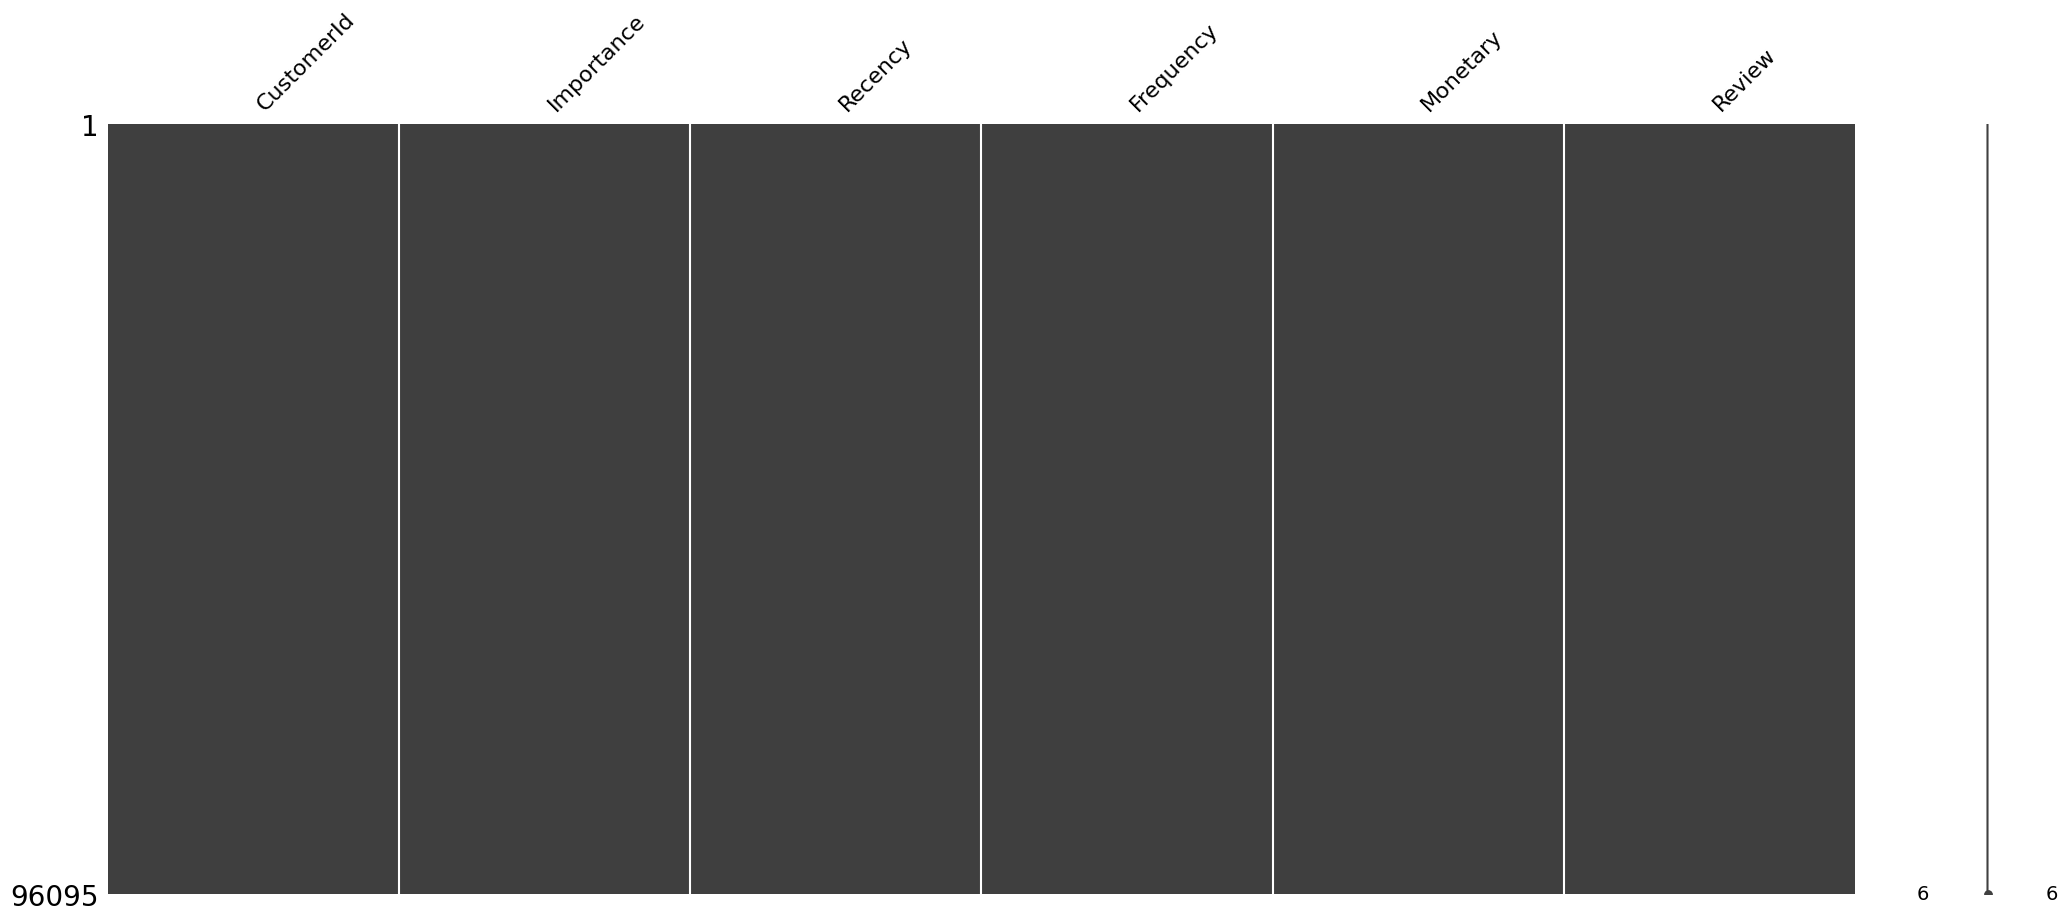

In [29]:
msno.matrix(cleaned_data)

In [30]:
total_na = cleaned_data.isna().sum().sum()
total_percent_na = (cleaned_data.isna().sum().sum() * 100 / cleaned_data.size).round(2) 
print("Nombre total de valeurs manquantes dans le dataset = ", total_na, "environ", total_percent_na,"% du dataset.")

Nombre total de valeurs manquantes dans le dataset =  0 environ 0.0 % du dataset.


In [31]:
# Initialisation du dictionnaire pour stocker les informations de complétion
completion = {}

# Calcul du nombre de valeurs non nulles, de valeurs manquantes et du pourcentage de valeurs manquantes pour chaque colonne
for var in cleaned_data.columns:
    nbr_values = cleaned_data[var].notna().sum()
    na_values = cleaned_data[var].isna().sum()
    completion[var] = [nbr_values, na_values]
    
# Affichage des informations de complétion pour chaque colonne
print('column_name : nbr_values -> nbr_of_Na', '\n')
for var in completion:
    nbr_values = completion[var][0]
    na_values = completion[var][1]
    print(f'{var} : {nbr_values} valeurs -> {int(na_values)} Na')

column_name : nbr_values -> nbr_of_Na 

CustomerId : 96095 valeurs -> 0 Na
Importance : 96095 valeurs -> 0 Na
Recency : 96095 valeurs -> 0 Na
Frequency : 96095 valeurs -> 0 Na
Monetary : 96095 valeurs -> 0 Na
Review : 96095 valeurs -> 0 Na


        3. Identification et traitement des valeurs  aberrantes

Nous allons réaliser un test de normalité afin de déterminer la meilleure approche pour détecter et traiter les valeurs aberrantes.

    - La méthode du Z-score est particulièrement efficace lorsque les données suivent une distribution normale.
    - La méthode de l'IQR est plus résistante aux valeurs aberrantes et convient mieux aux distributions non normales.

In [32]:
# Conversion de la colonne 'Recency' en type datetime
cleaned_data['Recency'] = pd.to_datetime(cleaned_data['Recency'], errors='coerce')

# Ensuite, convertir la colonne 'Recency' en nombre de jours depuis la date actuelle
cleaned_data['Recency'] = (pd.Timestamp.today() - cleaned_data['Recency']).dt.days

C:\Users\laure\AppData\Local\Temp\ipykernel_17392\2167307375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Recency'] = pd.to_datetime(cleaned_data['Recency'], errors='coerce')
C:\Users\laure\AppData\Local\Temp\ipykernel_17392\2167307375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Recency'] = (pd.Timestamp.today() - cleaned_data['Recency']).dt.days


In [33]:
# Niveau de signification (alpha)
alpha = 0.05

# Liste pour stocker les résultats
tests = []

# Variables quantitatives à tester
var_quant = ['Review', 'Monetary', 'Frequency', 'Recency']

for var in var_quant:
    # Récupérer les valeurs de la variable
    values = cleaned_data[var].dropna()

    # Effectuer les tests de normalité pour chaque variable
    shapiro_test = stats.shapiro(values)
    ks_test = stats.kstest(values, 'norm', N=len(values))
    ad_test = stats.anderson(values, dist='norm')
    dagostino_test = stats.normaltest(values)

    # Ajouter les résultats à la liste pour chaque test et variable
    tests.append({
        'Variable': var,
        'Shapiro-Wilk': shapiro_test[1] > alpha,
        'Kolmogorov-Smirnov': ks_test.pvalue > alpha,
        'Anderson-Darling': any(ad_test.statistic < crit_val for crit_val in ad_test.critical_values),
        'D\'Agostino-Pearson': dagostino_test.pvalue > alpha,
    })

# Création d'un DataFrame avec les résultats
test_results = pd.DataFrame(tests)

test_results

C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Variable,Shapiro-Wilk,Kolmogorov-Smirnov,Anderson-Darling,D'Agostino-Pearson
0,Review,False,False,False,False
1,Monetary,False,False,False,False
2,Frequency,False,False,False,False
3,Recency,False,False,False,False


In [34]:
# DataFrame vide pour enregistrer les valeurs aberrantes.
outliers_data = pd.DataFrame()

# Calculer les quartiles et l'IQR pour chaque colonne quantitative, et détecter les valeurs aberrantes
for var in ['Review', 'Monetary', 'Frequency', 'Recency']:
    Q1 = cleaned_data[var].quantile(0.25)
    Q3 = cleaned_data[var].quantile(0.75)
    IQR = Q3 - Q1
    
    # Filtrer les valeurs aberrantes en utilisant l'IQR
    outliers_filter = (cleaned_data[var] < (Q1 - 1.5 * IQR)) | (cleaned_data[var] > (Q3 + 1.5 * IQR))
    outliers = cleaned_data[outliers_filter]

    # Utiliser pd.concat au lieu de append
    outliers_data = pd.concat([outliers_data, outliers], ignore_index=True)

# Afficher les valeurs aberrantes pour chaque variable
print("Valeurs aberrantes détectées par variable :")
outliers_data

Valeurs aberrantes détectées par variable :


,CustomerId,Importance,Recency,Frequency,Monetary,Review
0,00053a61a98854899e70ed204dd4bafe,False,2431,1,419.18,0.000000
1,0005ef4cd20d2893f0d9fbd94d3c0d97,False,2418,1,129.76,0.000000
2,000de6019bb59f34c099a907c151d855,False,2625,1,257.44,0.250000
3,0010a452c6d13139e50b57f19f52e04e,False,2663,1,325.93,0.000000
4,0012929d977a8d7280bb277c1e5f589d,False,2564,1,155.65,0.000000
...,...,...,...,...,...,...
24516,ff922bdd6bafcdf99cb90d7f39cea5b3,True,2597,3,139.60,0.833333
24517,ffe254cc039740e17dd15a5305035928,True,2762,2,80.12,0.500000
24518,009b0127b727ab0ba422f6d9604487c7,False,2963,1,40.95,0.000000
24519,4854e9b3feff728c13ee5fc7d1547e92,False,2972,1,75.06,0.000000


In [35]:
# Calcul des centiles pour le montant dépensé (Monetary)
centiles_monetary = cleaned_data['Monetary'].quantile([.25, .5, .75, .9, .95, .99]).to_dict()

# Calcul des centiles pour la fréquence des achats (Frequency)
centiles_frequency = cleaned_data['Frequency'].quantile([.25, .5, .75, .9, .95, .99]).to_dict()

# Créer un DataFrame à partir des centiles
centiles_data = pd.DataFrame({
    'Centile': ['25%', '50%', '75%', '90%', '95%', '99%'],
    'Monetary': [centiles_monetary[0.25], centiles_monetary[0.5], centiles_monetary[0.75],
                 centiles_monetary[0.9], centiles_monetary[0.95], centiles_monetary[0.99]],
    'Frequency': [centiles_frequency[0.25], centiles_frequency[0.5], centiles_frequency[0.75],
                  centiles_frequency[0.9], centiles_frequency[0.95], centiles_frequency[0.99]]
})

# Afficher le DataFrame avec display (si dans Jupyter) ou print
centiles_data

,Centile,Monetary,Frequency
0,25%,63.1200,1.0
1,50%,108.0000,1.0
2,75%,183.5300,1.0
3,90%,319.5700,1.0
4,95%,476.1520,1.0
5,99%,1122.4662,2.0


J'ai déterminé que les variations présentes dans nos données sont représentatives de comportements d'achat typiques sur internet. La variabilité naturelle et l'examen des quantiles ayant démontré que la majorité des clients effectuent un achat unique, me permettent de ne pas qualifier ces fluctuations de valeurs aberrantes comme nécessitant une correction ou une exclusion de l'ensemble de données. 
Afin de préserver l'intégrité de l'analyse de segmentation et d'assurer que nos connaissances métier soient représentatives de toute les clients je décide de ne rien changer. 

III. Visualisation des données
******************************

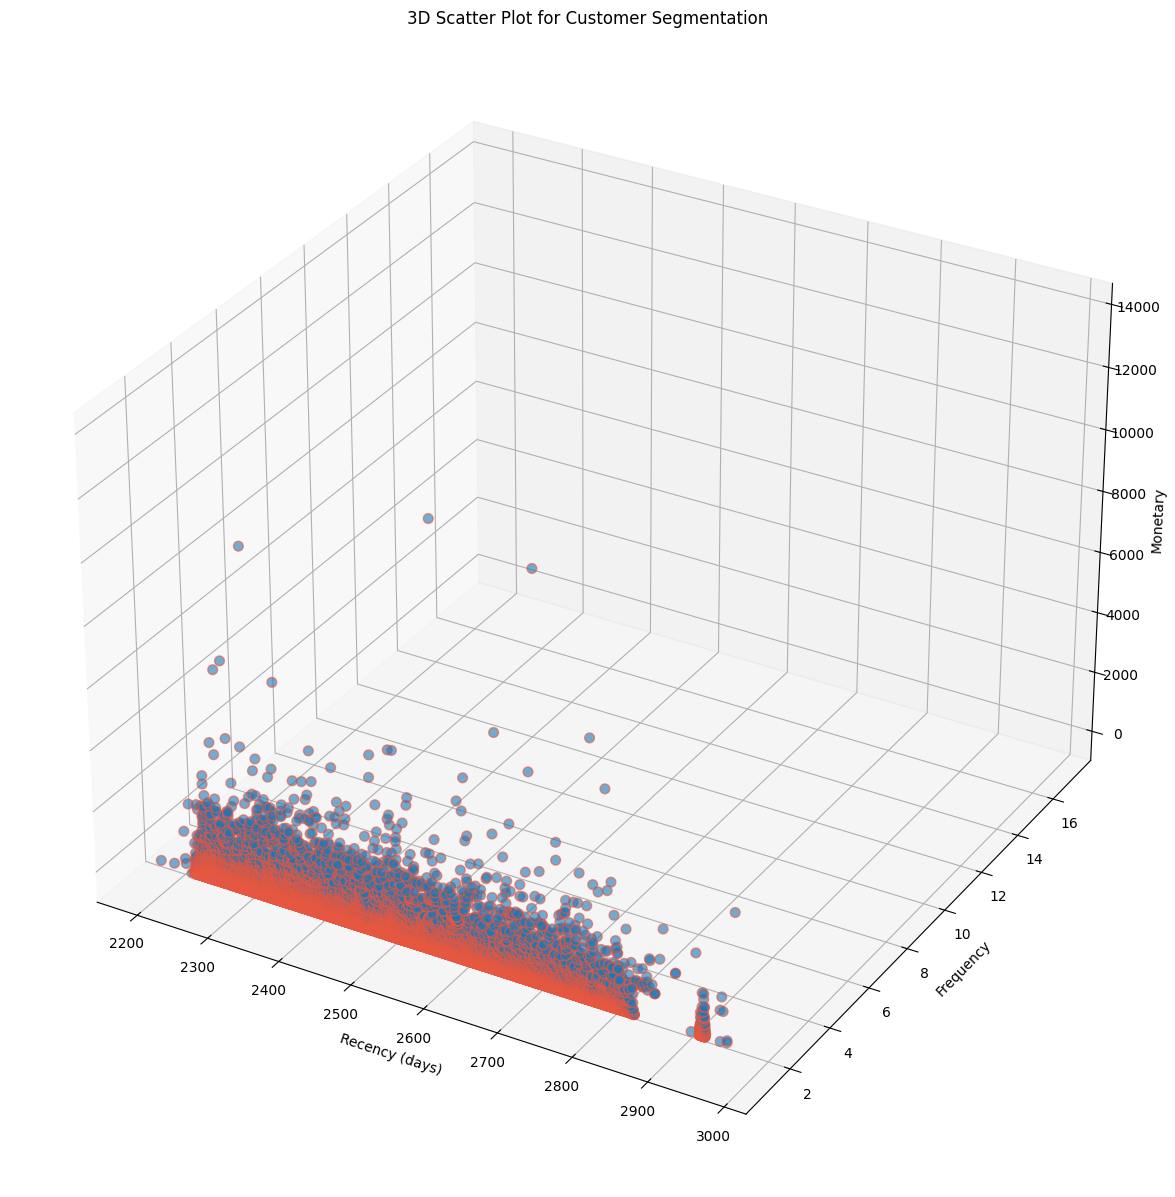

In [36]:
# Création de la figure et d'un axe 3D
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(111, projection='3d')

# Définition des axes X, Y et Z
x = cleaned_data['Recency']
y = cleaned_data['Frequency']
z = cleaned_data['Monetary']

# Création du nuage de points en 3D
scatter = ax.scatter(x, y, z, alpha=0.6, edgecolors='#e85741', s=50)

# Étiquettes des axes
ax.set_xlabel('Recency (days)')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Titre du graphique
ax.set_title('3D Scatter Plot for Customer Segmentation')

# Affichage du graphique
plt.show()

    A. Analyse univariée

        1. Mesures de variances

In [37]:
# Calcul des variances
var_recency = cleaned_data['Recency'].var()
var_frequency = cleaned_data['Frequency'].var()
var_monetary = cleaned_data['Monetary'].var()

# Création d'un dictionnaire
var_dict = {
    'Feature': ['Recency', 'Frequency', 'Monetary'],
    'Variance': [var_recency, var_frequency, var_monetary]
}

# Conversion du dictionnaire en DataFrame
var_data = pd.DataFrame(var_dict)

# Affichage du DataFrame
var_data

,Feature,Variance
0,Recency,23533.926133
1,Frequency,0.045961
2,Monetary,53559.341264


**Recency :** 

    --> variance élevée --> valeurs de `Recency` assez dispersées par rapport à la moyenne
    --> Certains clients ont passé une commande très récemment, tandis que d'autres n'ont pas commandé depuis longtemps.

**Frequency :** 

    --> variance faible --> valeurs de fréquence des commandes des clients sont assez proches les unes des autres
    --> La plupart des clients ont un nombre similaire de commandes, avec peu  de clients ayant des fréquences d'achat très élevées ou très faibles. 

**Monetary :**

    --> variance la plus élevée --> grande disparité dans les montants totaux dépensés par les clients
    --> Certains clients dépensent beaucoup plus que d'autres. Il y a des clients qui font de gros achats ou commandent fréquemment, tandis que d'autres font des achats plus modestes moins souvent.

        2. Mesures de tendance centrale

In [38]:
# Calculer la moyenne
mean_Recency = cleaned_data['Recency'].mean()
mean_Frequency = cleaned_data['Frequency'].mean()
mean_Monetary = cleaned_data['Monetary'].mean()

# Calculer la médiane
med_Recency = cleaned_data['Recency'].median()
med_Frequency = cleaned_data['Frequency'].median()
med_Monetary = cleaned_data['Monetary'].median()

# Calculer le mode
mode_Recency = cleaned_data['Recency'].mode().values[0]
mode_Frequency = cleaned_data['Frequency'].mode().values[0]
mode_Monetary = cleaned_data['Monetary'].mode().values[0]

# Création d'un dictionnaire
tc_dict = {
        'Recency': {'Moyenne': mean_Recency, 'Mediane': med_Recency, 'Mode': mode_Recency},
        'Frequency': {'Moyenne': mean_Frequency, 'Mediane': med_Frequency, 'Mode': mode_Frequency},
        'Monetary': {'Moyenne': mean_Monetary, 'Mediane': med_Monetary, 'Mode': mode_Monetary}
}

# Conversion du dictionnaire en DataFrame
tc_data = pd.DataFrame(tc_dict)

# Affichage du DataFrame
tc_data

,Recency,Frequency,Monetary
Moyenne,2487.504438,1.034809,166.594226
Mediane,2468.000000,1.000000,108.000000
Mode,2526.000000,1.000000,77.570000


**Recency :** 

    --> En moyenne, les clients ont passé leur dernière commande il y a 2486 jours --> inactivité ou une faible fréquence d'achat.
    --> La médiane de 2467 jours indique que la répartition des derniers achats est légèrement inclinée vers des périodes plus longues.
    --> Le mode de 2525 jours est la valeur de récence la plus fréquente parmi les clients --> le nombre le plus élevé de clients a passé leur dernière commande il y a 2525 jours.

**Frequency :** 

    --> En moyenne, les clients ont passé 1 commande --> avec quelques exceptions.
    --> La médiane est de 1, ce qui confirme que plus de la moitié des clients ont passé une seule commande.
    --> Le mode est également 1, renforçant l'observation que la majorité des clients ont passé une seule commande.

**Monetary :**

    --> En moyenne, les clients ont dépensé environ 167 unités monétaires. Cette moyenne peut être influencée par quelques gros acheteurs.
    --> La médiane est de 108 (très inférieur à la moyenne) --> la majorité des clients dépensent moins que la moyenne, avec quelques clients dépensant beaucoup plus.
    --> Le mode de 77,57 est la dépense la plus fréquente. Cela indique que la plupart des clients dépensent autour de 77 unités monétaires pour leurs achats.


**Implications Générales**

- Engagement Client : La récence relativement élevée suggère un manque d'engagement régulier des clients avec l'entreprise.

- Fréquence d'Achat : La fréquence montre que la plupart des clients ne sont pas des acheteurs répétés.

- Dépenses des Clients : La distribution des dépenses indique une grande variété dans le comportement des clients en termes de dépenses totales, avec quelques clients dépensant beaucoup plus que la moyenne.

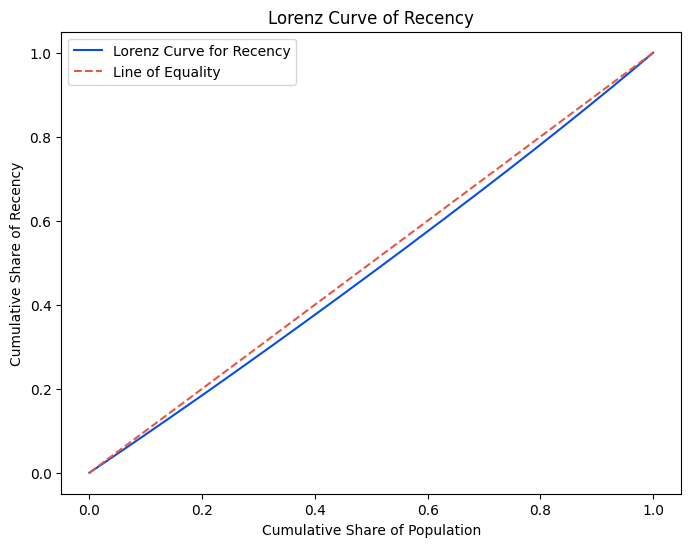

GINI Coefficient for Recency: -0.0351


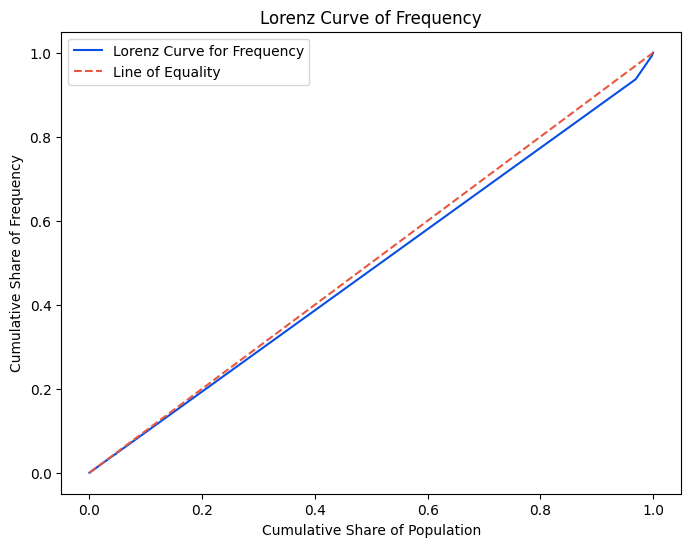

GINI Coefficient for Frequency: -0.0327


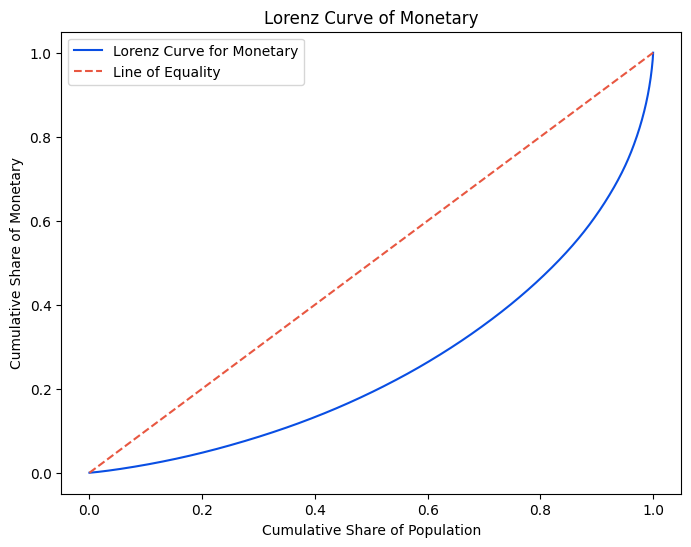

GINI Coefficient for Monetary: -0.4811


In [39]:
def plot_lorenz_gini(data, feature_name):
    # Tri des valeurs de la variable
    sorted_values = np.sort(data[feature_name].dropna())  # Suppression des valeurs NaN

    # Calcul des proportions cumulées
    cumulative_population = np.linspace(0, 1, len(sorted_values))
    cumulative_variable = np.cumsum(sorted_values) / sorted_values.sum()

    # Tracé de la courbe de Lorenz
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_population, cumulative_variable, label='Lorenz Curve for ' + feature_name, color='#094ee3')
    plt.plot([0, 1], [0, 1], linestyle='--', color='#e85741', label='Line of Equality')
    plt.xlabel('Cumulative Share of Population')
    plt.ylabel('Cumulative Share of ' + feature_name)
    plt.title('Lorenz Curve of ' + feature_name)
    plt.legend()
    plt.show()

    # Calcul de l'aire sous la courbe de Lorenz
    auc = metrics.auc(cumulative_population, cumulative_variable)

    # Calcul du coefficient de Gini
    gini_coefficient = 2 * (auc - 0.5)

    print("GINI Coefficient for " + feature_name + ": {:.4f}".format(gini_coefficient))

# Appliquer la fonction aux caractéristiques
plot_lorenz_gini(cleaned_data, 'Recency')
plot_lorenz_gini(cleaned_data, 'Frequency')
plot_lorenz_gini(cleaned_data, 'Monetary')

Les mesures de concentration permettent d'évaluer si une variable est également répartie (ou non) entre différents individus.

Elles évaluent le degré de concentration des valeurs autour de la moyenne. Une mesure courante est le coefficient de variation (CV), qui est le rapport de l'écart-type à la moyenne.

La courbe de Lorenz permet de représenter la répartition d'une variable au sein d'une population, notamment si elle est égalitaire ou non.

Le coefficient de GINI permet d'évaluer de façon chiffrée cette répartition. Il correspond à deux fois l'aire sous la courbe de Lorenz.

    B. Analyse bivariée

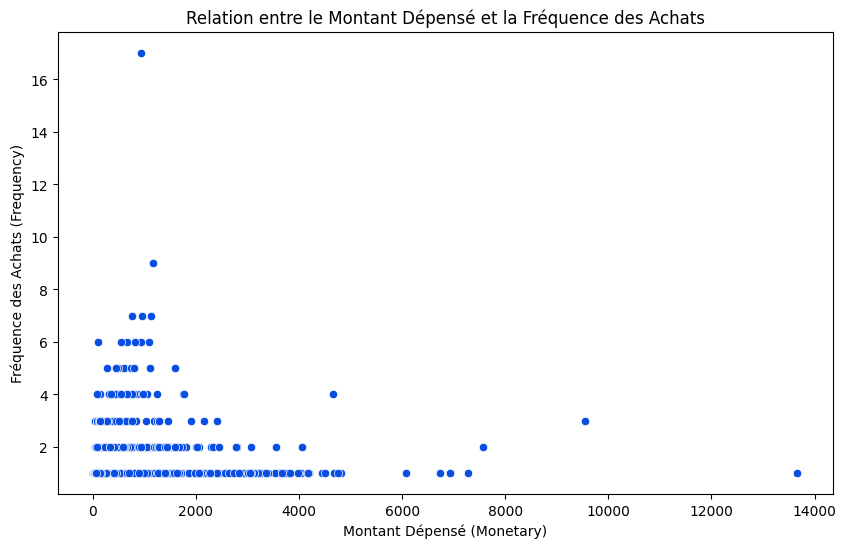

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_data, x='Monetary', y='Frequency', color='#094ee3')

plt.title('Relation entre le Montant Dépensé et la Fréquence des Achats')
plt.xlabel('Montant Dépensé (Monetary)')
plt.ylabel('Fréquence des Achats (Frequency)')

# Pour voir le graphique
plt.show()

In [41]:
# Calcul du coefficient de corrélation de Pearson
pearson_corr, _ = st.pearsonr(cleaned_data["Monetary"], cleaned_data["Frequency"])
print(f"Coefficient de corrélation de Pearson entre Monetary et Frequency : {pearson_corr}")

# Calcul de la covariance
covariance = np.cov(cleaned_data["Monetary"], cleaned_data["Frequency"], ddof=0)[0, 1]
print(f"Covariance entre Monetary et Frequency : {covariance}")

Coefficient de corrélation de Pearson entre Monetary et Frequency : 0.1260313371157167
Covariance entre Monetary et Frequency : 6.252960871910211


In [42]:
# Sélection des variables quantitatives
var_quant = ['Monetary', 'Frequency']  

# Définition de la fonction pour tracer différents plots interactifs qui prend une variable quantitative comme argument
@interact
def interact_plot(var=var_quant):
    plt.figure(figsize=(15, 15))  # Ajuster la taille de la figure pour plus de clarté
    
    # Boxplot
    plt.subplot(3, 1, 1)
    sns.boxplot(x=cleaned_data[var], color='#e85741')    
    plt.title("Boxplot pour : " + str(var), fontsize=15)    

    # Violinplot
    plt.subplot(3, 1, 2)
    sns.violinplot(x=cleaned_data[var], color='#094ee3')
    plt.title("Violinplot pour : " + str(var), fontsize=15)

    # Histogramme
    plt.subplot(3, 1, 3)
    sns.histplot(cleaned_data[var], color='#eba165', bins=50, kde=True)  # Ajout de kde pour la densité
    plt.ylabel("Nombre d'individus", fontsize=7)
    plt.title("Distribution de : " + str(var), fontsize=15)

    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='var', options=('Monetary', 'Frequency'), value='Monetary'), Output…

Les résultats de nos analyses indiquent une corrélation modeste entre le montant dépensé et la fréquence des achats, avec un coefficient de Pearson de 0.126.

Cela suggère une légère tendance pour les clients qui dépensent plus à acheter légèrement plus fréquemment. Cependant, la covariance de 6.25 indique que cette relation n'est pas fortement linéaire.

La distribution des dépenses et de la fréquence des achats, montre un large éventail de comportements d'achat, avec quelques valeurs extrêmes qui ne sont pas considérées comme des aberrations dans le contexte de l'e-commerce.

Ainsi, notre analyse reflète une variété de comportements d'achat qui sont représentatifs de la clientèle globale du site.

In [43]:
cleaned_data.to_csv('../Data/cleaned_data.csv', index=False)